### Import
For Load Data Section

In [15]:
import os
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Load Data

To develop a generalizable architecture for fault diagnosis, we utilize two benchmark datasets: **KAIST** and **CWRU**.

- **KAIST Dataset:** The Korea Advanced Institute of Science & Technology (KAIST) dataset contains vibration signals from rotating machinery under various fault types, motor loads, and fault severities. It provides a diverse set of conditions, making it suitable for robust model training and evaluation.

- **CWRU Dataset:** The Case Western Reserve University (CWRU) bearing dataset is widely used for bearing fault diagnosis research. It includes vibration data collected under different fault types, locations, and loads.

By training the ML model on both KAIST and CWRU datasets, we aim to demonstrate its ability to generalize across different machines, fault types, and operating conditions.

## KAIST Dataset
The KAIST Dataset (Jung2022) has 4 sensed variables: acoustic, current, temperature, and vibration. In this case, only vibration will be used.
- **Machine Conditions (Normal, BPFI, BPFO, Misalign, and Unbalance):** Fault types and normal operating condition
- **Motor load (0Nm, 2Nm, 4Nm):** Torque applied to the motor simulating load
- **Fault Severity:** Depending on the type of fault there are at least 3 severities. For example BPFI has a fault severity represented in the crack width (0.3mm, 1mm, 3mm)

In [2]:
# ------------------------------ KAIST Dataset ------------------------------
# Paths and parameters
vibration_mat_folder_kaist = '../../data/raw_kaist/vibration_mat_25.6kHz'
v_length_kaist = 1536000  # length of the smaller vector in the dataset
sampling_rate_kaist = 25600  # fixed at 25.6 kHz

# Class labels for different domains
class_labels_kaist0 = ['0Nm_Normal', '0Nm_BPFI_03', '0Nm_BPFO_03', '0Nm_Misalign_01', '0Nm_Unbalance_0583mg']
class_labels_kaist1 = ['2Nm_Normal', '2Nm_BPFI_03', '2Nm_BPFO_03', '2Nm_Misalign_01', '2Nm_Unbalance_0583mg']
class_labels_kaist2 = ['4Nm_Normal', '4Nm_BPFI_03', '4Nm_BPFO_03', '4Nm_Misalign_01', '4Nm_Unbalance_0583mg']

def load_domain_data_kaist(class_labels, domain_name):
    """Load vibration data for a domain, using CSV cache if available."""
    vibration_data = {}

    folder_path = f'../../data/flex-data/kaist_csv/vibration{sampling_rate_kaist/1000}kHz_domain{domain_name}'
    os.makedirs(folder_path, exist_ok=True)

    print(f"Loading domain {domain_name}...")

    for label in class_labels:
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder_kaist, f"{label}.mat")

        # Try CSV first, fall back to .mat
        if os.path.exists(csv_path):
            print(f"  Loading {label} from CSV...")
            vibration_data[label] = pd.read_csv(csv_path).values
        elif os.path.exists(mat_path):
            print(f"  Loading {label} from .mat file...")
            mat_data = sio.loadmat(mat_path)
            vibration = mat_data['Signal']['y_values'][0][0][0][0][0][:v_length_kaist, :]
            vibration_data[label] = vibration

            # Save to CSV for next time
            print(f"  Saving {label} to CSV...")
            pd.DataFrame(vibration_data[label]).to_csv(csv_path, index=False)
        else:
            print(f"  Warning: {label} not found")

    print(f"Domain {domain_name} loaded: {len(vibration_data)} classes")
    return vibration_data

# Load all domains
vibration_data_kaist0 = load_domain_data_kaist(class_labels_kaist0, '0Nm')
vibration_data_kaist1 = load_domain_data_kaist(class_labels_kaist1, '2Nm')
vibration_data_kaist2 = load_domain_data_kaist(class_labels_kaist2, '4Nm')

vibration_data_kaist = {**vibration_data_kaist0, **vibration_data_kaist1, **vibration_data_kaist2}
class_labels_kaist = list(vibration_data_kaist.keys())


Loading domain 0Nm...
  Loading 0Nm_Normal from .mat file...
  Saving 0Nm_Normal to CSV...
  Loading 0Nm_BPFI_03 from .mat file...
  Saving 0Nm_BPFI_03 to CSV...
  Loading 0Nm_BPFO_03 from .mat file...
  Saving 0Nm_BPFO_03 to CSV...
  Loading 0Nm_Misalign_01 from .mat file...
  Saving 0Nm_Misalign_01 to CSV...
  Loading 0Nm_Unbalance_0583mg from .mat file...
  Saving 0Nm_Unbalance_0583mg to CSV...
Domain 0Nm loaded: 5 classes
Loading domain 2Nm...
  Loading 2Nm_Normal from .mat file...
  Saving 2Nm_Normal to CSV...
  Loading 2Nm_BPFI_03 from .mat file...
  Saving 2Nm_BPFI_03 to CSV...
  Loading 2Nm_BPFO_03 from .mat file...
  Saving 2Nm_BPFO_03 to CSV...
  Loading 2Nm_Misalign_01 from .mat file...
  Saving 2Nm_Misalign_01 to CSV...
  Loading 2Nm_Unbalance_0583mg from .mat file...
  Saving 2Nm_Unbalance_0583mg to CSV...
Domain 2Nm loaded: 5 classes
Loading domain 4Nm...
  Loading 4Nm_Normal from .mat file...
  Saving 4Nm_Normal to CSV...
  Loading 4Nm_BPFI_03 from .mat file...
  Saving 

### Plot Random KAIST signal

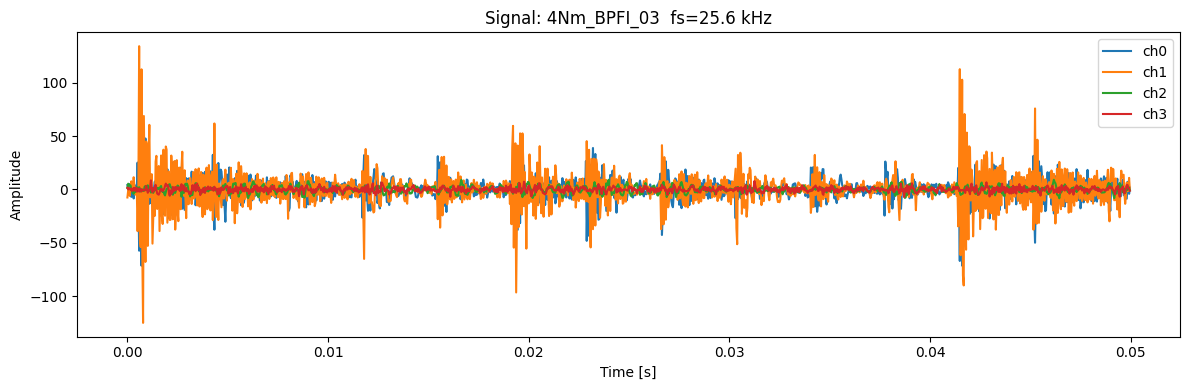

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_signal(data_dict, fs, seconds=0.1, channels=None, label=None, title_prefix="Signal"):
    """
    Plot a short time span from a selected or random signal.
    
    Parameters
    ----------
    data_dict : dict[label] -> np.ndarray [samples, channels]
        Dictionary of signals.
    fs : int
        Sampling rate in Hz.
    seconds : float
        Duration of the plotted segment in seconds.
    channels : list[int] or None
        Which channels to plot (0-based). None means all.
    label : str or None
        If provided, plot this class label; if None, pick randomly.
    title_prefix : str
        Title prefix for the plot.
    """
    if not data_dict:
        raise ValueError("data_dict is empty")

    # Choose label
    if label is None:
        label = random.choice(list(data_dict.keys()))
    elif label not in data_dict:
        raise ValueError(f"Label '{label}' not found. Available: {list(data_dict.keys())[:5]}...")

    x = data_dict[label]
    if x.ndim == 1:
        x = x[:, None]

    n_show = min(int(seconds * fs), x.shape[0])
    if n_show < 1:
        raise ValueError("seconds too small for given fs")

    if channels is None:
        ch_idx = range(x.shape[1])
    else:
        ch_idx = [c for c in channels if 0 <= c < x.shape[1]]

    t = np.arange(n_show) / fs

    plt.figure(figsize=(12, 4))
    for c in ch_idx:
        plt.plot(t, x[:n_show, c], label=f"ch{c}")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(f"{title_prefix}: {label}  fs={fs/1000:.1f} kHz")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Usage
# KAIST at 25.6 kHz
plot_signal(vibration_data_kaist, fs=sampling_rate_kaist, seconds=0.05)
# plot_signal(vibration_data_kaist, fs=sampling_rate_kaist, seconds=0.05, label='0Nm_Normal', channels=[0])



## CWRU Dataset
The Case Western Reserve University (CWRU) Bearing Dataset provides vibration measurements collected from a motor test rig with seeded bearing faults. Acceleration data was captured near the motor bearings under varying load and fault conditions.

- **Machine Conditions (Normal, Inner Race, Outer Race, and Ball Faults):** Single-point faults were introduced using electro-discharge machining (EDM) at the inner race, outer race, or rolling element. Normal operating condition data is also included.  
- **Motor Load (0–3 hp):** Torque loads applied to the 2 hp Reliance Electric motor, corresponding to operating speeds between 1720 and 1797 RPM.  
- **Fault Severity:** Fault diameters of 0.007, 0.014, 0.021, 0.028, and 0.040 inches were tested. SKF bearings were used for smaller faults (7–21 mils) and NTN bearings for larger faults (28–40 mils).  
- **Sensor Setup:** Vibration was recorded using accelerometers placed at the 12 o’clock position of the drive end and fan end bearings. Additional measurements were taken at the base plate in some experiments.  
- **Sampling Rate:** Signals were collected at 12 kHz for most cases, with 48 kHz recordings available for drive end bearing faults.  


In [5]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.signal import resample_poly

# ------------------------------ CWRU Dataset ------------------------------
# Paths and parameters
# Keep your original folder. The code will resample whatever it loads.
vibration_mat_folder_cwru = '../../data/raw_cwru/vibration_mat_12kHz'  # or .../vibration_mat_12kHz if that is your source
v_length_cwru = 1536000  # length to trim before resampling if needed
sampling_rate_cwru = 12000
target_sampling_rate_cwru = 25600  # target sampling rate for resampling

# Integer ratio for exact 12 kHz -> 25.6 kHz conversion
UPSAMPLE = 32
DOWNSAMPLE = 15
assert abs(target_sampling_rate_cwru * DOWNSAMPLE - sampling_rate_cwru * UPSAMPLE) == 0, "Sampling rates must match 32 over 15 ratio"

# Class labels for different domains
class_labels_cwru0 = ['B007_0', 'IR007_0', 'Normal_0', 'OR007@3_0', 'OR007@6_0', 'OR007@12_0']
class_labels_cwru1 = ['B007_1', 'IR007_1', 'Normal_1', 'OR007@3_1', 'OR007@6_1', 'OR007@12_1']
class_labels_cwru2 = ['B007_2', 'IR007_2', 'Normal_2', 'OR007@3_2', 'OR007@6_2', 'OR007@12_2']


import numpy as np
import scipy.io as sio

def _load_mat_signal(mat_path, max_len=None, channels=("DE", "FE", "BA")):
    """
    Load CWRU vibration from .mat and return a 2D array [time, channels].
    Channels are taken in order DE, FE, BA if present.
    Ignores the *RPM scalar.
    """
    m = sio.loadmat(mat_path)

    # Collect available channels by suffix pattern *_<CH>_time
    series = []
    lengths = []
    for ch in channels:
        # Find the key that ends with _<CH>_time, e.g., X118_DE_time
        key = next((k for k in m.keys() if not k.startswith('__') and k.endswith(f"_{ch}_time")), None)
        if key is not None:
            arr = np.asarray(m[key]).squeeze()
            if arr.ndim != 1:
                arr = arr.reshape(-1)
            series.append(arr)
            lengths.append(arr.shape[0])

    if not series:
        raise ValueError(f"No DE FE BA time series found in {mat_path}")

    # Use the shortest available length to align channels
    n = min(lengths)
    if max_len is not None:
        n = min(n, int(max_len))

    # Stack as columns in the requested channel order
    stacked = np.stack([s[:n] for s in series], axis=1).astype(np.float32, copy=False)
    return stacked



def _resample_to_target(x_2d, up=UPSAMPLE, down=DOWNSAMPLE):
    """Resample along the time axis keeping channels in columns."""
    # x_2d shape: [time, channels]
    y = resample_poly(x_2d, up, down, axis=0)
    return y.astype(np.float32, copy=False)


def load_domain_data_cwru(class_labels, domain_name):
    """Load and resample vibration data to the target rate, using CSV cache if available."""
    vibration_data = {}

    # Cache directory is tied to the target sampling rate
    folder_path = f'../../data/flex-data/cwru_csv/vibration{target_sampling_rate_cwru/1000}kHz_domain{domain_name}'
    os.makedirs(folder_path, exist_ok=True)

    print(f"Loading domain {domain_name} at {target_sampling_rate_cwru} Hz...")

    for label in class_labels:
        csv_path = f'{folder_path}/{label}.csv'
        mat_path = os.path.join(vibration_mat_folder_cwru, f"{label}.mat")

        if os.path.exists(csv_path):
            print(f"  Loading {label} from resampled CSV cache...")
            vibration_data[label] = pd.read_csv(csv_path).values
            continue

        if os.path.exists(mat_path):
            print(f"  Loading {label} from .mat file and resampling...")
            x = _load_mat_signal(mat_path, max_len=v_length_cwru)
            y = _resample_to_target(x, UPSAMPLE, DOWNSAMPLE)

            # Optional deterministic length control from source trimming
            # Expected resampled length based on v_length_cwru
            expected_len = int(round(v_length_cwru * target_sampling_rate_cwru / sampling_rate_cwru))
            if y.shape[0] != expected_len:
                # Trim or pad to expected length if you need strict alignment across classes
                if y.shape[0] > expected_len:
                    y = y[:expected_len, :]
                else:
                    pad = np.zeros((expected_len - y.shape[0], y.shape[1]), dtype=y.dtype)
                    y = np.vstack([y, pad])

            vibration_data[label] = y

            print(f"  Saving {label} resampled CSV...")
            pd.DataFrame(y).to_csv(csv_path, index=False)
        else:
            print(f"  Warning: {label} not found in cache or mats")

    print(f"Domain {domain_name} loaded: {len(vibration_data)} classes at {target_sampling_rate_cwru} Hz")
    return vibration_data


# Load all domains already resampled to 25.6 kHz
vibration_data_cwru0 = load_domain_data_cwru(class_labels_cwru0, '0HP')
vibration_data_cwru1 = load_domain_data_cwru(class_labels_cwru1, '1HP')
vibration_data_cwru2 = load_domain_data_cwru(class_labels_cwru2, '2HP')

vibration_data_cwru = {**vibration_data_cwru0, **vibration_data_cwru1, **vibration_data_cwru2}
class_labels_cwru = list(vibration_data_cwru.keys())


Loading domain 0HP at 25600 Hz...
  Loading B007_0 from resampled CSV cache...
  Loading IR007_0 from resampled CSV cache...
  Loading Normal_0 from resampled CSV cache...
  Loading OR007@3_0 from resampled CSV cache...
  Loading OR007@6_0 from resampled CSV cache...
  Loading OR007@12_0 from resampled CSV cache...
Domain 0HP loaded: 6 classes at 25600 Hz
Loading domain 1HP at 25600 Hz...
  Loading B007_1 from resampled CSV cache...
  Loading IR007_1 from resampled CSV cache...
  Loading OR007@3_1 from resampled CSV cache...
  Loading OR007@6_1 from resampled CSV cache...
  Loading OR007@12_1 from resampled CSV cache...
Domain 1HP loaded: 5 classes at 25600 Hz
Loading domain 2HP at 25600 Hz...
  Loading B007_2 from resampled CSV cache...
  Loading IR007_2 from resampled CSV cache...
  Loading OR007@3_2 from resampled CSV cache...
  Loading OR007@6_2 from resampled CSV cache...
  Loading OR007@12_2 from resampled CSV cache...
Domain 2HP loaded: 5 classes at 25600 Hz


Plot Random signal CWRU

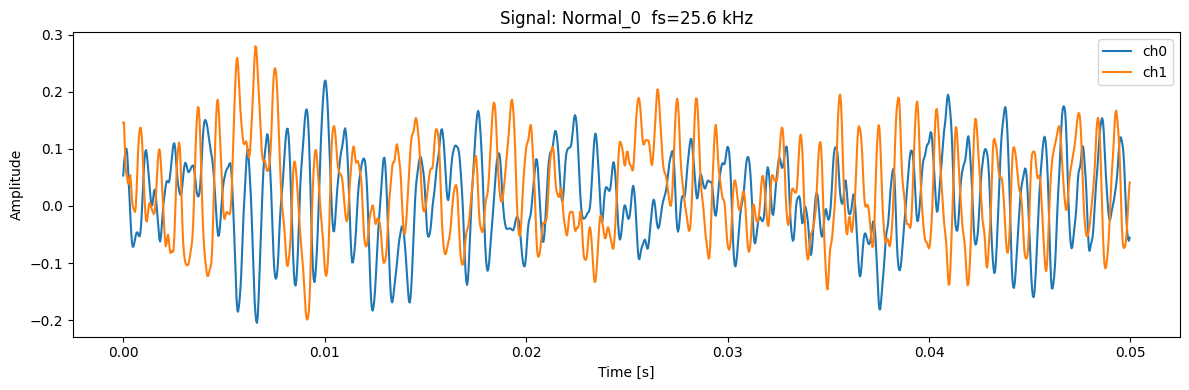

In [39]:
# CWRU after your resampling step at 25.6 kHz
# plot_signal(vibration_data_cwru, fs=target_sampling_rate_cwru, seconds=0.05)
plot_signal(vibration_data_cwru, fs=target_sampling_rate_cwru, seconds=0.05, label='Normal_0')

### Resampling visualization CWRU Dataset

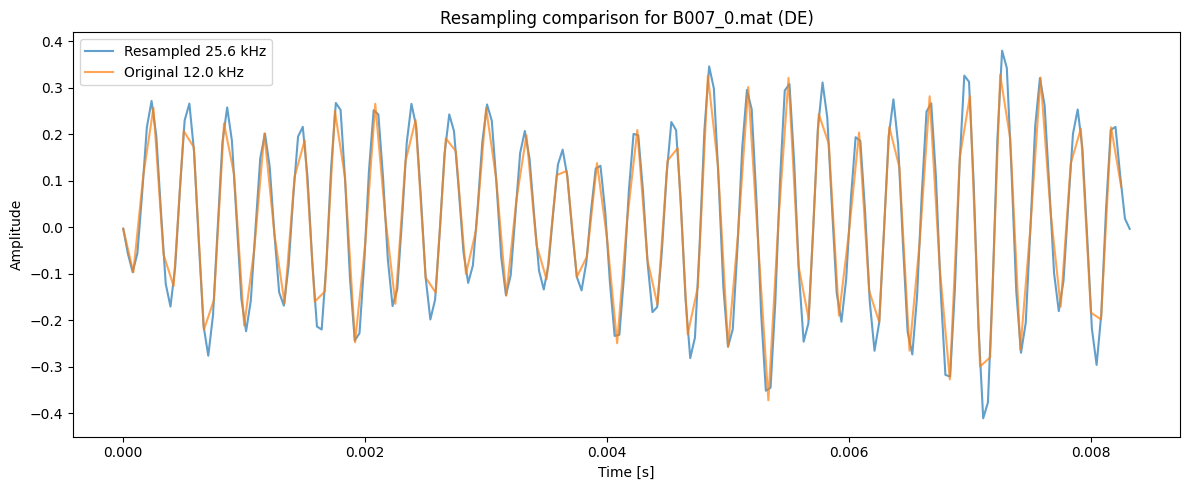

In [45]:
def compare_resampling(mat_path, channel="DE", max_len=6000):
    """
    Plot a short segment of the original and resampled signals
    from a given CWRU .mat file.
    """
    # Load raw signal at 12 kHz
    x = _load_mat_signal(mat_path, max_len=max_len, channels=(channel,))
    # Resample to 25.6 kHz
    y = _resample_to_target(x, UPSAMPLE, DOWNSAMPLE)

    # Time axes
    t_orig = np.arange(x.shape[0]) / sampling_rate_cwru
    t_resampled = np.arange(y.shape[0]) / target_sampling_rate_cwru

    plt.figure(figsize=(12, 5))
    plt.plot(t_resampled, y[:,0], label=f"Resampled {target_sampling_rate_cwru/1000:.1f} kHz", alpha=0.7)
    plt.plot(t_orig, x[:,0], label=f"Original {sampling_rate_cwru/1000:.1f} kHz", alpha=0.7)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(f"Resampling comparison for {os.path.basename(mat_path)} ({channel})")
    plt.legend()
    plt.tight_layout()
    plt.show()

mat_path = "../../data/raw_cwru/vibration_mat_12kHz/B007_0.mat"
compare_resampling(mat_path, channel="DE", max_len=100)

# Model Definition

In [4]:
# keras >= 2.9
import tensorflow as tf
from tensorflow.keras import layers, models

# ----- helpers -----
def crelu(x):
    return layers.Concatenate(axis=-1)([layers.ReLU()(x), layers.ReLU()(-x)])

def sep_res_block(x, filters, ksize=9, stride=1, name="b"):
    # depthwise separable conv via SeparableConv1D
    y = layers.SeparableConv1D(filters, ksize, strides=stride, padding="same", use_bias=False, name=f"{name}_sep")(x)
    y = layers.BatchNormalization(name=f"{name}_bn")(y)
    y = crelu(y)
    # match shape for residual
    if stride != 1 or x.shape[-1] != filters:
        skip = layers.Conv1D(filters, 1, strides=stride, padding="same", use_bias=False, name=f"{name}_proj")(x)
        skip = layers.BatchNormalization(name=f"{name}_proj_bn")(skip)
    else:
        skip = x
    out = layers.Add(name=f"{name}_add")([y, skip])
    return out

def build_model(input_length, n_channels, n_classes_main, use_aux_or_location=True, n_or_locations=3):
    inp = layers.Input(shape=(input_length, n_channels), name="signal")

    # ----- stem -----
    x = layers.Conv1D(32, 64, strides=4, padding="same", use_bias=False, name="stem_conv")(inp)
    x = layers.BatchNormalization(name="stem_bn")(x)
    x = crelu(x)  # efficient first layer feature doubling

    # ----- stages -----
    x = sep_res_block(x, 64,  ksize=9, stride=2, name="s1_b1")
    x = sep_res_block(x, 64,  ksize=9, stride=1, name="s1_b2")

    x = sep_res_block(x, 128, ksize=9, stride=2, name="s2_b1")
    x = sep_res_block(x, 128, ksize=9, stride=1, name="s2_b2")

    x = sep_res_block(x, 128, ksize=9, stride=1, name="s3_b1")
    x = sep_res_block(x, 128, ksize=9, stride=1, name="s3_b2")

    # ----- heads -----
    x = layers.GlobalAveragePooling1D(name="gap")(x)
    h = layers.Dense(100, activation="relu", name="neck")(x)

    main_out = layers.Dense(n_classes_main, activation="softmax", name="cls_main")(h)

    outputs = [main_out]

    if use_aux_or_location:
        aux_out = layers.Dense(n_or_locations, activation="softmax", name="cls_or_loc")(h)
        outputs.append(aux_out)

    return models.Model(inp, outputs, name="LDR_1D_CNN")

# ----- compile with masked auxiliary loss -----
def compile_with_aux_mask(model, aux_weight=0.2):
    # y_true for main is one hot. For aux, pass an extra mask channel at the end.
    # Shape for aux y_true: [..., n_or_locations + 1], where last position is 1.0 if label present else 0.0
    def masked_ce(y_true, y_pred):
        y, m = y_true[..., :-1], y_true[..., -1:]
        ce = tf.keras.losses.categorical_crossentropy(y, y_pred)
        ce = ce * tf.squeeze(m, axis=-1)
        denom = tf.maximum(tf.reduce_mean(m), 1e-6)
        return tf.reduce_sum(ce) / denom

    losses = {"cls_main": "categorical_crossentropy"}
    loss_weights = {"cls_main": 1.0}

    if "cls_or_loc" in [o.name for o in model.outputs]:
        losses["cls_or_loc"] = masked_ce
        loss_weights["cls_or_loc"] = aux_weight

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=losses, loss_weights=loss_weights,
                  metrics={"cls_main": ["accuracy"]})
    return model
